In [ ]:
!pip install factor_analyzer
!pip install -U plotly

In [99]:
# для обработки данных
import numpy as np 
import pandas as pd

# для работы с переменными и компонентами
from sklearn.decomposition import FactorAnalysis, PCA
from pandas.plotting import scatter_matrix
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from scipy.stats.stats import pearsonr

# для построения моделей
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# **1. Анализ  и обработка данных**


---


**Раздел включает в себя:**
* предварительная обработка данных;
* разведочный анализ данных.


## **1.1. Предварительная обработка данных**



**Подраздел включает в себя:**
* обзор данных;
* анализ признаков;
* удаление заведомо ненужных признаков;
* обработка пропусков и категориальных признаков.

### 1.1.1. Обзор данных

Данные файла `CC GENERAL.csv` обобщают поведение около $9\ 000$ активных держателей кредитных карт за последние $6$ месяцев. 

Файл содержит $18$ поведенческих переменных клиентов:

| Переменная |Описание переменной |
| --- | --- |
| CUST ID | номер клиента |
| BALANCE  | сумма остатка на их счету |
| BALANCEFREQUENCY  | как часто обновляется баланс |
| PURCHASES  | сумма покупок |
| ONEOFFPURCHASES  | максимальная сумма единовременной покупки |
| INSTALLMENTSPURCHASES  | сумма покупки в рассрочку |
| CASHADVANCE  | предоставление наличных денег пользователем |
| PURCHASESFREQUENCY  | как часто совершаются покупки, от 0 до 1 (1 = часто покупают, 0 = редко покупают) |
| ONEOFFPURCHASESFREQUENCY   | как часто совершаются разовые покупки (1 = часто покупаются, 0 = редко покупаются) |
| PURCHASESINSTALLMENTSFREQUENCY   | как часто совершаются покупки в рассрочку (1 = часто, 0 = редко) |
| CASHADVANCEFREQUENCY  | как часто выплачиваются наличные авансом |
| CASHADVANCETRX   | количество транзакций, совершенных с помощью «Cash in Advanced» |
| PURCHASESTRX   | количество совершенных транзакций покупки |
| CREDITLIMIT   | лимит кредитной карты для пользователя |
| PAYMENTS    | сумма платежа, сделанного пользователем |
| MINIMUM_PAYMENTS   | минимальная сумма платежей пользователя |
| PRCFULLPAYMENT    | процент от полной оплаты, уплаченный пользователем |
| TENURE    | срок обслуживания кредитной карты для пользователя |

In [100]:
credit = pd.read_csv('CC GENERAL.csv')
credit.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [101]:
# размерность данных
credit.shape

(8950, 18)

In [102]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

**Вывод по краткому обзору данных:** 
1. Наш датафрейм имеет $8\ 950$ строк и $18$ колонок (переменных). 
2. Названия переменных соответствуют их смыслу, однако стоит изменить их в стиле `snake_case`.
3. Все переменные — количественные, кроме `CUST_ID`, отражающего идентификационных номер клиента.


In [103]:
credit.rename(columns=str.lower, inplace=True)
credit.head()

cust_id      balance  balance_frequency  purchases  oneoff_purchases  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   installments_purchases  cash_advance  purchases_frequency  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      payments  minimum_payments  prc_full_payment  tenure  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

### 1.1.2. Анализ признаков

In [104]:
credit.describe()

balance  balance_frequency     purchases  oneoff_purchases  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       installments_purchases  cash_advance  purchases_frequency  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       oneoff_purchases_frequency  purchases_installments_frequency  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           payments  minimum_payments  prc_full_payment       tenure  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

In [105]:
# названия количественных переменных
credit.describe().columns

Index(['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure'],
      dtype='object')

Рассмотрим число уникальных значений признаков:

In [106]:
# все переменные
credit_vars = credit.columns
credit_vars[0]

'cust_id'

In [107]:
for i in range(len(credit_vars)):
  print(f"Число уникальных значений в признаке {str(credit_vars[i]).ljust(35)} - "
    f"{str(credit[credit_vars[i]].nunique()).rjust(5)}")

Число уникальных значений в признаке cust_id                             -  8950
Число уникальных значений в признаке balance                             -  8871
Число уникальных значений в признаке balance_frequency                   -    43
Число уникальных значений в признаке purchases                           -  6203
Число уникальных значений в признаке oneoff_purchases                    -  4014
Число уникальных значений в признаке installments_purchases              -  4452
Число уникальных значений в признаке cash_advance                        -  4323
Число уникальных значений в признаке purchases_frequency                 -    47
Число уникальных значений в признаке oneoff_purchases_frequency          -    47
Число уникальных значений в признаке purchases_installments_frequency    -    47
Число уникальных значений в признаке cash_advance_frequency              -    54
Число уникальных значений в признаке cash_advance_trx                    -    65
Число уникальных значений в 

**Вывод по анализу переменных:** 
1. Данные содержат только одну категориальную переменную: `cust_id`, содержательно она нам неинтересна, поэтому ее мы не анализировали. 
2. Вариация значений количественных переменных отвечает реальности и их смыслу. 
3. Есть несколько переменных, вызывающих сомнения, так как вариация их уникальных значений очень мала: `balance_frequency`, `purchases_frequency`, `oneoff_purchases_frequency`, `purchases_installments_frequency`, `cash_advance_frequency`, `cash_advance_trx`, `purchases_trx`, `credit_limit`, `prc_full_payment`, `tenure`. Решение об их удалении мы примем в последующих разделах и подразделах.

### 1.1.3. Удаление заведомо ненужных признаков

In [108]:
# контролируем размерность данных, чтобы не потерять их случайно
credit.shape

(8950, 18)

**Вывод по удалению заведомо ненужных переменных:**
* переменные, которые под вопросом, мы не трогаем, так как они связаны с аналогичными переменными, отраженными в абсолютных величинах;
* мы не выделили заведомо ненужные переменные, так как они могут быть значимы при кластеризации.

### 1.1.4. Обработка пропусков и категориальных переменных

In [109]:
# проверим датасет на наличие пропусков
# есть значения NaN
credit.isnull().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

In [110]:
credit.loc[(credit['minimum_payments'].isnull()==True), 'minimum_payments'] = credit['minimum_payments'].mean()
credit.loc[(credit['credit_limit'].isnull()==True),'credit_limit'] = credit['credit_limit'].mean()

In [111]:
credit.isnull().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [112]:
credit.shape

(8950, 18)

**Вывод по обработке пропусков и категориальных переменных:**
* все пропуски были заменены на среднее значение по признаку;
* категориальная переменная `cust_id` не была обработана, так как она является только индексом в данных. 

## **1.2. Разведочный анализ данных**



**Подраздел включает в себя:**
* определение выбросов и их обработка;
* одномерный анализ;
* многомерный анализ.

### 1.2.1. Определение выбросов и их обработка

Выбросы в наборах данных влияют на качество выводов. По этой причине выбросы в наших данных, для чего построим визуализацию:

In [113]:
# переменные, которые мы проверим на выбросы
data_col = (credit.columns).to_list()
del data_col[0]
del data_col[-1]
data_col

['balance',
 'balance_frequency',
 'purchases',
 'oneoff_purchases',
 'installments_purchases',
 'cash_advance',
 'purchases_frequency',
 'oneoff_purchases_frequency',
 'purchases_installments_frequency',
 'cash_advance_frequency',
 'cash_advance_trx',
 'purchases_trx',
 'credit_limit',
 'payments',
 'minimum_payments',
 'prc_full_payment']

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass t

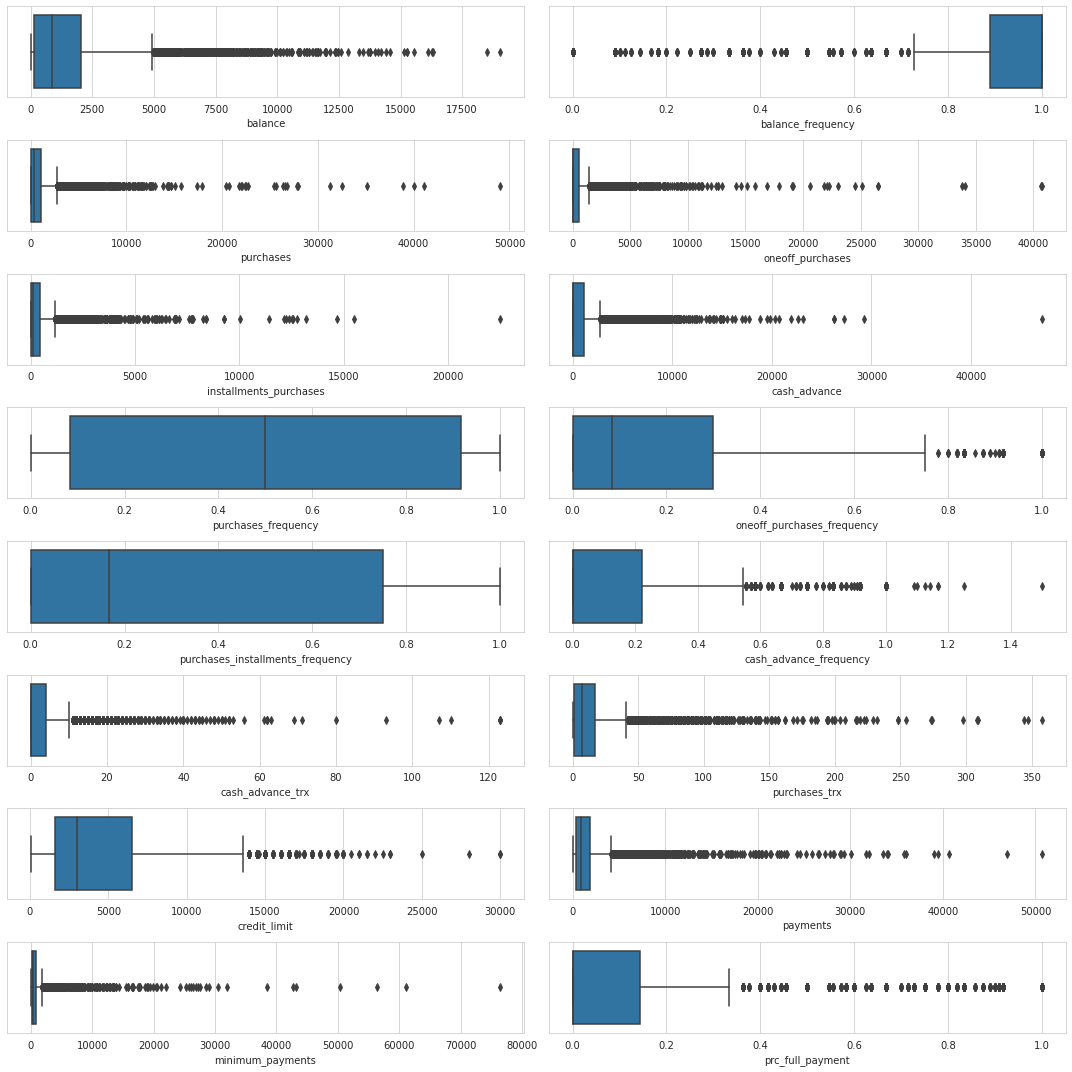

In [114]:
fig, axs = plt.subplots(8, 2, figsize=(15, 15))

plt1 = sns.boxplot(credit['balance'], ax=axs[0, 0])
plt2 = sns.boxplot(credit['balance_frequency'], ax=axs[0, 1])

plt3 = sns.boxplot(credit['purchases'], ax=axs[1, 0])
plt4 = sns.boxplot(credit['oneoff_purchases'], ax=axs[1, 1])

plt5 = sns.boxplot(credit['installments_purchases'], ax=axs[2, 0])
plt6 = sns.boxplot(credit['cash_advance'], ax=axs[2, 1])

plt7 = sns.boxplot(credit['purchases_frequency'], ax=axs[3, 0])
plt8 = sns.boxplot(credit['oneoff_purchases_frequency'], ax=axs[3, 1])

plt9 = sns.boxplot(credit['purchases_installments_frequency'], ax=axs[4, 0])
plt10 = sns.boxplot(credit['cash_advance_frequency'], ax=axs[4, 1])

plt11 = sns.boxplot(credit['cash_advance_trx'], ax=axs[5, 0])
plt12 = sns.boxplot(credit['purchases_trx'], ax=axs[5, 1])

plt13 = sns.boxplot(credit['credit_limit'], ax=axs[6, 0])
plt14 = sns.boxplot(credit['payments'], ax=axs[6, 1])

plt15 = sns.boxplot(credit['minimum_payments'], ax=axs[7, 0])
plt16 = sns.boxplot(credit['prc_full_payment'], ax=axs[7, 1])

plt.tight_layout()

In [115]:
# объявление функции для обработки выбросов
def outliers(data, column):
    """"Функция обрабатывет выбросы с помощью квантилей 0.25 и 0.75."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    for i in range(len(data)):
        if data[column].iloc[i] > upper_bound:
            data[column].iloc[i] = upper_bound
        if data[column].iloc[i] < lower_bound:
            data[column].iloc[i] = lower_bound


# вызов функции для обработки выбросов 
for feature in data_col:
    outliers(credit, feature)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Проверим результат обработки выбросов:

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass t

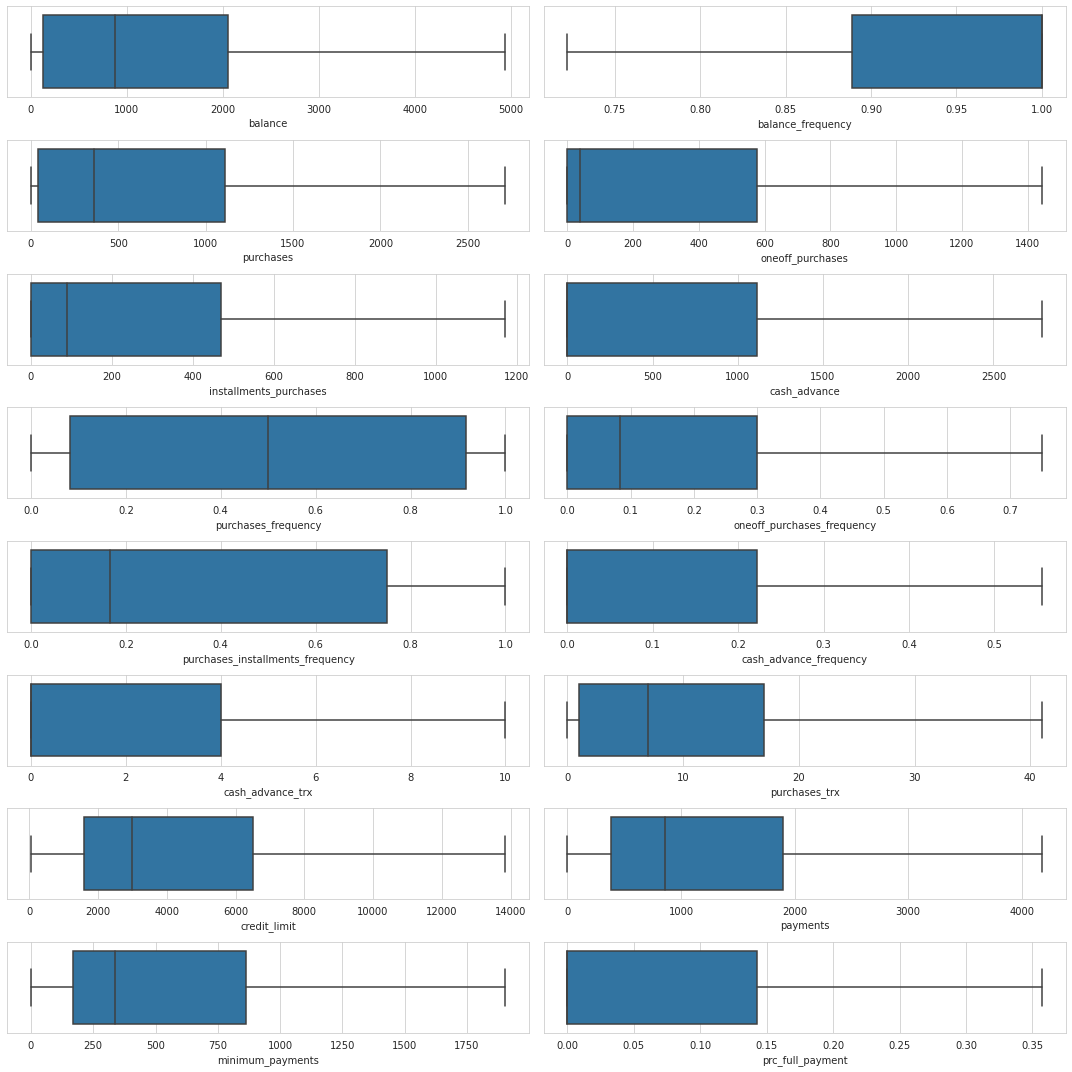

In [116]:
fig, axs = plt.subplots(8, 2, figsize=(15, 15))

plt1 = sns.boxplot(credit['balance'], ax=axs[0, 0])
plt2 = sns.boxplot(credit['balance_frequency'], ax=axs[0, 1])

plt3 = sns.boxplot(credit['purchases'], ax=axs[1, 0])
plt4 = sns.boxplot(credit['oneoff_purchases'], ax=axs[1, 1])

plt5 = sns.boxplot(credit['installments_purchases'], ax=axs[2, 0])
plt6 = sns.boxplot(credit['cash_advance'], ax=axs[2, 1])

plt7 = sns.boxplot(credit['purchases_frequency'], ax=axs[3, 0])
plt8 = sns.boxplot(credit['oneoff_purchases_frequency'], ax=axs[3, 1])

plt9 = sns.boxplot(credit['purchases_installments_frequency'], ax=axs[4, 0])
plt10 = sns.boxplot(credit['cash_advance_frequency'], ax=axs[4, 1])

plt11 = sns.boxplot(credit['cash_advance_trx'], ax=axs[5, 0])
plt12 = sns.boxplot(credit['purchases_trx'], ax=axs[5, 1])

plt13 = sns.boxplot(credit['credit_limit'], ax=axs[6, 0])
plt14 = sns.boxplot(credit['payments'], ax=axs[6, 1])

plt15 = sns.boxplot(credit['minimum_payments'], ax=axs[7, 0])
plt16 = sns.boxplot(credit['prc_full_payment'], ax=axs[7, 1])

plt.tight_layout()

In [117]:
# контролируем размерность данных
credit.shape

(8950, 18)

**Вывод по обработке выбросов:**
* все выбросы были обработаны с помощью квантилей $0.25$ и $0.75$;
* размер данных не был уменьшен, чтобы не потерять их качество.

### 1.2.2. Одномерный анализ

In [118]:
credit.describe().iloc[-1]

balance                              4942.927215
balance_frequency                       1.000000
purchases                            2715.872500
oneoff_purchases                     1443.512500
installments_purchases               1171.593750
cash_advance                         2784.552848
purchases_frequency                     1.000000
oneoff_purchases_frequency              0.750000
purchases_installments_frequency        1.000000
cash_advance_frequency                  0.555555
cash_advance_trx                       10.000000
purchases_trx                          41.000000
credit_limit                        13850.000000
payments                             4177.921543
minimum_payments                     1904.229874
prc_full_payment                        0.357143
tenure                                 12.000000
Name: max, dtype: float64

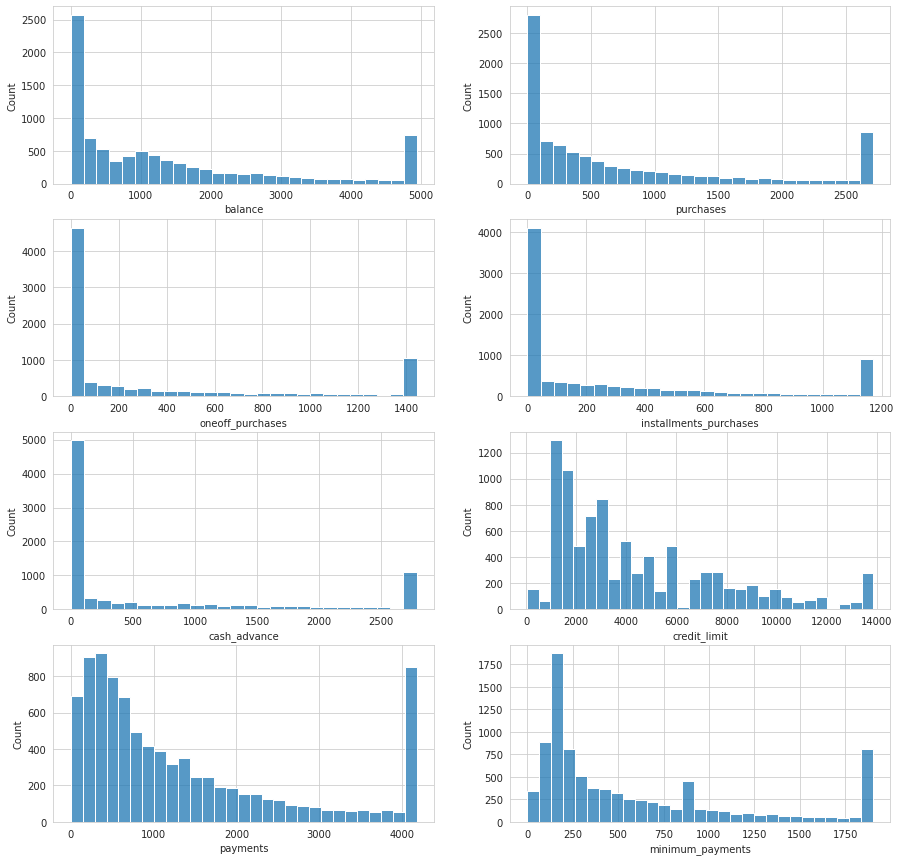

In [119]:
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

plt1 = sns.histplot(data=credit, x='balance', ax=axs[0, 0])
plt2 = sns.histplot(data=credit, x='purchases', ax=axs[0, 1])

plt3 = sns.histplot(data=credit, x='oneoff_purchases', ax=axs[1, 0])
plt4 = sns.histplot(data=credit, x='installments_purchases', ax=axs[1, 1])

plt5 = sns.histplot(data=credit, x='cash_advance', ax=axs[2, 0])
plt6 = sns.histplot(data=credit, x='credit_limit', ax=axs[2, 1])

plt7 = sns.histplot(data=credit, x='payments', ax=axs[3, 0])
plt8 = sns.histplot(data=credit, x='minimum_payments', ax=axs[3, 1])

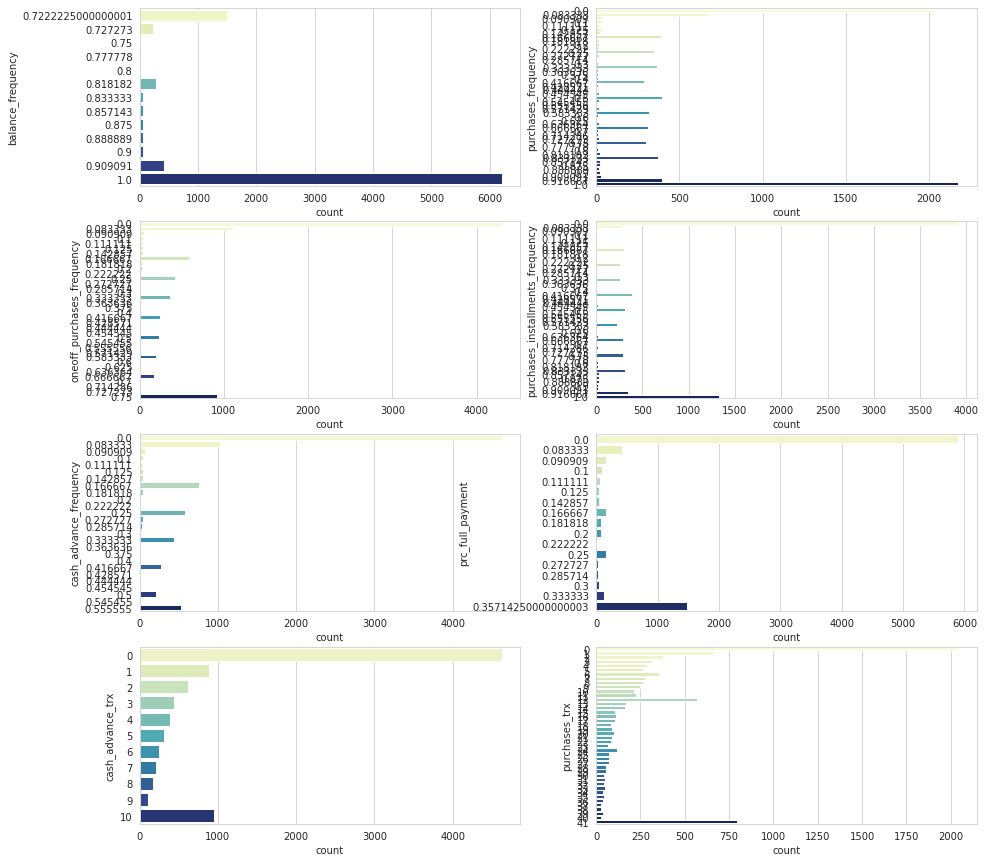

In [120]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(4, 2, figsize=(15, 15))

plt1 = sns.countplot(y='balance_frequency', data=credit, palette='YlGnBu', ax=axs[0, 0])
plt2 = sns.countplot(y='purchases_frequency', data=credit, palette='YlGnBu', ax=axs[0, 1])

plt3 = sns.countplot(y='oneoff_purchases_frequency', data=credit, palette='YlGnBu', ax=axs[1, 0])
plt4 = sns.countplot(y='purchases_installments_frequency', data=credit, palette='YlGnBu', ax=axs[1, 1])

plt5 = sns.countplot(y='cash_advance_frequency', data=credit, palette='YlGnBu', ax=axs[2, 0])
plt6 = sns.countplot(y='prc_full_payment', data=credit, palette='YlGnBu', ax=axs[2, 1])

plt7 = sns.countplot(y='cash_advance_trx', data=credit, palette='YlGnBu', ax=axs[3, 0])
plt8 = sns.countplot(y='purchases_trx', data=credit, palette='YlGnBu', ax=axs[3, 1])

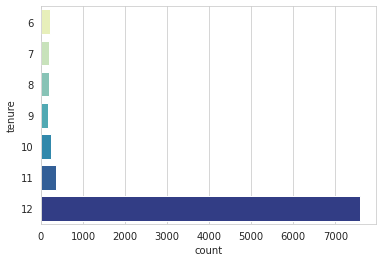

In [121]:
sns.countplot(y='tenure', data=credit, palette='YlGnBu')

In [122]:
data = credit.copy()
columns = ['balance', 'purchases', 'oneoff_purchases', 'installments_purchases', 
           'cash_advance', 'credit_limit',
           'payments', 'minimum_payments']      

for c in columns:
    
    Range = c + '_RANGE'
    data[Range] = 0        
    data.loc[((data[c] > 0) & (data[c] <= 500)), Range] = 1
    data.loc[((data[c] > 500) & (data[c] <= 1_000)), Range] = 2
    data.loc[((data[c] > 1_000) & (data[c] <= 3_000)), Range] = 3
    data.loc[((data[c] > 3_000) & (data[c] <= 5_000)), Range] = 4
    data.loc[((data[c] > 5_000) & (data[c] <= 10_000)), Range] = 5
    data.loc[((data[c] > 10_000)), Range] = 6

In [123]:
columns = ['balance_frequency', 'purchases_frequency', 
         'oneoff_purchases_frequency', 'purchases_installments_frequency', 
         'cash_advance_frequency', 'prc_full_payment']             

for c in columns:
    
    Range = c + '_RANGE'
    data[Range] = 0
    data.loc[((data[c] > 0) & (data[c] <= 0.1)), Range] = 1
    data.loc[((data[c] > 0.1) & (data[c] <= 0.2)), Range] = 2
    data.loc[((data[c] > 0.2) & (data[c] <= 0.3)), Range] = 3
    data.loc[((data[c] > 0.3) & (data[c] <= 0.4)), Range] = 4
    data.loc[((data[c] > 0.4) & (data[c] <= 0.5)), Range] = 5
    data.loc[((data[c] > 0.5) & (data[c] <= 0.6)), Range] = 6
    data.loc[((data[c] > 0.6) & (data[c] <= 0.7)), Range] = 7
    data.loc[((data[c] > 0.7) & (data[c] <= 0.8)), Range] = 8
    data.loc[((data[c] > 0.8) & (data[c] <= 0.9)), Range] = 9
    data.loc[((data[c] > 0.9) & (data[c] <= 1.0)), Range] = 10

In [124]:
columns = ['purchases_trx', 'cash_advance_trx']  

for c in columns:
    
    Range= c + '_RANGE'
    data[Range] = 0
    data.loc[((data[c] > 0) & (data[c] <= 5)), Range] = 1
    data.loc[((data[c] > 5 ) & (data[c] <= 10)), Range] = 2
    data.loc[((data[c] > 10) & (data[c] <= 15)), Range] = 3
    data.loc[((data[c] > 15) & (data[c] <= 20)), Range] = 4
    data.loc[((data[c] > 20) & (data[c] <= 30)),Range] = 5
    data.loc[((data[c] > 30) & (data[c] <= 50)),Range] = 6
    data.loc[((data[c] > 50) & (data[c] <= 100)),Range] = 7
    data.loc[((data[c] > 100)), Range] = 8

In [125]:
data.drop(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment' ], axis=1, inplace=True)
data.head()     

tenure  balance_RANGE  purchases_RANGE  oneoff_purchases_RANGE  \
0      12              1                1                       0   
1      12              4                0                       0   
2      12              3                2                       2   
3      12              3                3                       3   
4      12              2                1                       1   

   installments_purchases_RANGE  cash_advance_RANGE  credit_limit_RANGE  \
0                             1                   0                   2   
1                             0                   3                   5   
2                             0                   0                   5   
3                             0                   1                   5   
4                             0                   0                   3   

   payments_RANGE  minimum_payments_RANGE  balance_frequency_RANGE  \
0               1                       1                        9   
1               4                       3                       10   
2               2                       2                       10   
3               0                       2                        8   
4               2                       1                       10   

   purchases_frequency_RANGE  oneoff_purchases_frequency_RANGE  \
0                          2                                 0   
1                          0                                 0   
2                         10                                 8   
3                          1                                 1   
4                          1                                 1   

   purchases_installments_frequency_RANGE  cash_advance_frequency_RANGE  \
0                                       1                             0   
1                                       0                             3   
2                                       0                             0   
3                                       0                             1   
4                                       0                             0   

   prc_full_payment_RANGE  purchases_trx_RANGE  cash_advance_trx_RANGE  
0                       0                    1                       0  
1                       3                    0                       1  
2                       0                    3                       0  
3                       0                    1                       1  
4                       0                    1                       0

In [126]:
data.balance_RANGE.value_counts(sort=False)

1    3598
4    1451
3    2699
2    1122
0      80
Name: balance_RANGE, dtype: int64

In [127]:
labels = ['0', '0:500', '500:1000', '1000:3000', '3000:5000', '5000:10000', '>10000']
fig = go.Figure(data=[go.Pie(labels=labels, values=data.balance_RANGE.value_counts(sort=False), hole = .3)])
fig.layout.update(title='BALANCE', autosize=False,
    width=600,
    height=400)
fig

Таким образом, большинство клиентов имеют либо нулевой остаток на счету, либо ненулевой, но меньший $1000$ у.е. 

In [128]:
fig = go.Figure(data=[go.Pie(labels=labels, values=data.purchases_RANGE.value_counts(sort=False),hole = .3)])
fig.layout.update(title='PURCHASES', autosize=False,
    width=600,
    height=400)
fig

Большинство людей совсем не пользовались своими кредитными картами для совершения покупок.

In [129]:
fig = go.Figure(data=[go.Pie(labels=labels, values=data.oneoff_purchases_RANGE.value_counts(sort=False),hole = .3)])
fig.layout.update(title='ONEOFF_PURCHASES', autosize=False,
    width=600,
    height=400)
fig

Отсюда видно, что, поскольку большинство людей совсем не совершали покупки, то и максимальной единовременной покупкой для большинства из них также и будет $0$ у.е.

In [130]:
fig = go.Figure(data=[go.Pie(labels=labels, values=data.installments_purchases_RANGE.value_counts(sort=False),hole = .3)])
fig.layout.update(title='INSTALLMENTS_PURCHASES', autosize=False,
    width=600,
    height=400)
fig

Исходя из диаграммы выше, можно сделать вывод о непопулярности совершения покупок в рассрочку.

In [131]:
fig = go.Figure(data=[go.Pie(labels=labels, values=data.cash_advance_RANGE.value_counts(sort=False),hole = .3)])
fig.layout.update(title='CASH_ADVANCE', autosize=False,
    width=600,
    height=400)
fig

Таким образом, клиенты в целом не совершают наличных платежей авансом.

In [132]:
fig = go.Figure(data=[go.Pie(labels=labels, values=data.payments_RANGE.value_counts(sort=False),hole = .3)])
fig.layout.update(title='PAYMENTS', autosize=False,
    width=600,
    height=400)
fig

Большинство платежей было совершено на сумму между $3000$ и $5000$ у.е., либо не совершено совсем.

In [133]:
MINIMUM_PAYMENTS_values=[data.minimum_payments_RANGE[data['minimum_payments_RANGE']==1].count(), \
                         data.minimum_payments_RANGE[data['minimum_payments_RANGE']==2].count(), \
                         data.minimum_payments_RANGE[data['minimum_payments_RANGE']==3].count(), \
                         data.minimum_payments_RANGE[data['minimum_payments_RANGE']==4].count(), \
                         data.minimum_payments_RANGE[data['minimum_payments_RANGE']==5].count(), \
                         data.minimum_payments_RANGE[data['minimum_payments_RANGE']==6].count()]
MINIMUM_PAYMENTS_labels = ['0:500', '500:1000', '1000:3000', '3000:5000', '5000:10000', '>10000']

fig = go.Figure(data=[go.Pie(labels=MINIMUM_PAYMENTS_labels, values=MINIMUM_PAYMENTS_values,hole = .3)])
fig.layout.update(title='MINIMUM_PAYMENTS', autosize=False,
    width=600,
    height=400)
fig

Отсюда видно, что большинство клиентов совершали минимальные платежи в размере от $0$ до $500$ у.е.

**Выводы по одномерному анализу:**
* все распределения величин в абсолютных значениях при первом приближении похожи, больше всего повторяют друг друга: `oneoff_purchases`, `installments_purchases`, `cash_advance`.
* в распределениях частот наблюдаются периодические скачки.
* из признаков, выраженных в относительных величинах, не представляют интереса следующие в силу неполноты данных и их вариативности: `balance_frequency`, `oneoff_purchases_frequency`, `cash_advance_frequency`, `prc_full_payment`.
* из признаков, выраженных в абсолютных величинах, не представляют интереса следующие в силу повторямости смысла с другими признаками: `installments_purchases`, `oneoff_purchases`.


### 1.2.3. Многомерный анализ

In [134]:
data_col.append('tenure')
data_col

['balance',
 'balance_frequency',
 'purchases',
 'oneoff_purchases',
 'installments_purchases',
 'cash_advance',
 'purchases_frequency',
 'oneoff_purchases_frequency',
 'purchases_installments_frequency',
 'cash_advance_frequency',
 'cash_advance_trx',
 'purchases_trx',
 'credit_limit',
 'payments',
 'minimum_payments',
 'prc_full_payment',
 'tenure']

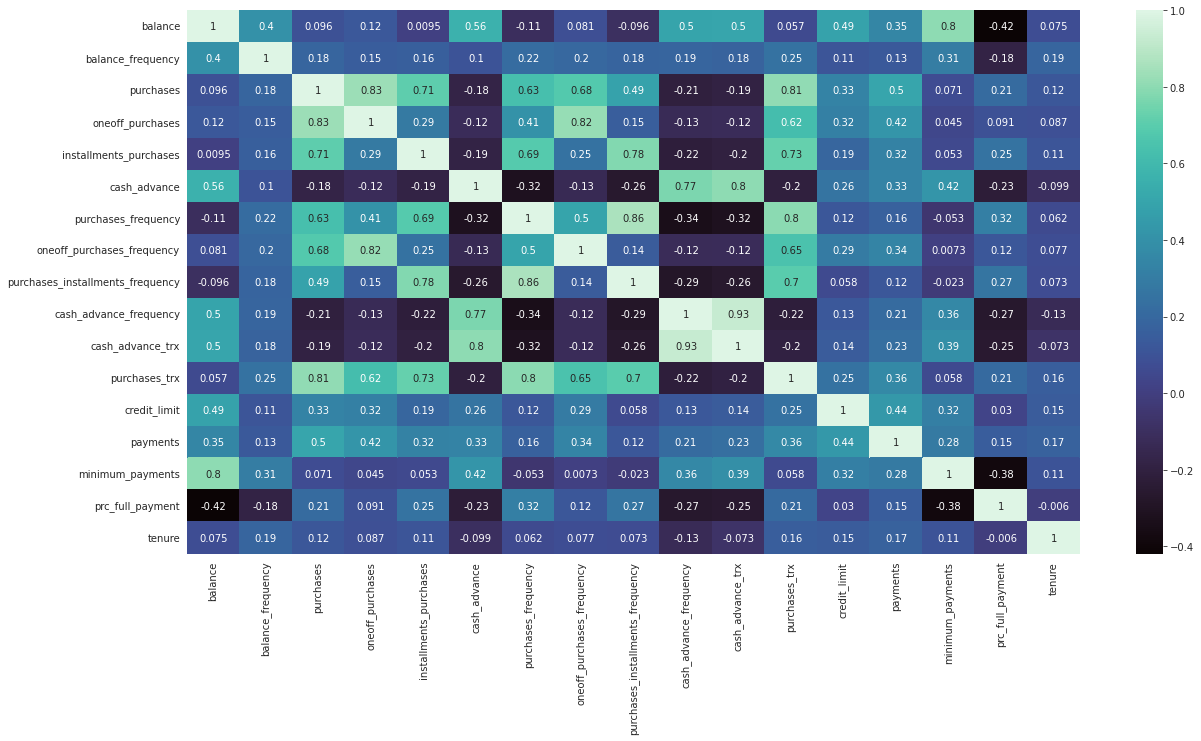

In [135]:
fig = plt.subplots(figsize=(20, 10))

corr_matrix = credit.loc[:, data_col].corr()
sns.heatmap(corr_matrix, annot=True, cmap='mako')

In [136]:
credit.drop(columns='prc_full_payment').corrwith(credit['prc_full_payment'])

balance                            -0.419972
balance_frequency                  -0.183459
purchases                           0.212936
oneoff_purchases                    0.091038
installments_purchases              0.254259
cash_advance                       -0.227197
purchases_frequency                 0.316356
oneoff_purchases_frequency          0.123273
purchases_installments_frequency    0.266671
cash_advance_frequency             -0.268737
cash_advance_trx                   -0.254650
purchases_trx                       0.211653
credit_limit                        0.030297
payments                            0.146739
minimum_payments                   -0.384348
tenure                             -0.005955
dtype: float64

**Выводы по многомерному анализу:**
* для каждой переменной выделим те признаки, корреляция с которыми выше $0.4$ (не тождественные по содержанию);
* `balance`: `cash_advance`, `cash_advance_frequency`, `cash_advance_trx`, `credit_limit`, `minimum_payments`, `prc_full_payment`; 
* `purchases`: `payments`;
* `oneoff_purchases`: `payments`;
* `cash_advance`: `minimum_payments`;
* `credit_limit`: `payments`.

# **2. Построение моделей**
 
 ---

**Раздел включает в себя:**
* кластерный анализ (модель №$1$);
* метод главных компонент;
* кластерный анализ (модель №$2$).

## **2.1. Кластерный анализ**



**Подраздел включает в себя:**
* построение модели кластеризации: метод `k-means`;
* описание полученных кластеров;
* выбор наилучшей модели.


Учитывая результаты одномерного и многомерного анализа отберем несколько признаков для кластеризации:
* `balance`;
* `purchases`;
* `cash_advance`;
* `minimum_payments`;
* `credit_limit`;
* `payments`. 

In [140]:
# подготовка данных для моделей
data_1 = credit.drop(['cust_id', 'balance_frequency', 'oneoff_purchases', 
                      'installments_purchases', 'purchases_frequency',
                      'oneoff_purchases_frequency', 'purchases_installments_frequency',
                      'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
                      'prc_full_payment', 'tenure'], axis=1)
data_1.head()

balance  purchases  cash_advance  credit_limit     payments  \
0    40.900749      95.40      0.000000        1000.0   201.802084   
1  3202.467416       0.00   2784.552848        7000.0  4103.032597   
2  2495.148862     773.17      0.000000        7500.0   622.066742   
3  1666.670542    1499.00    205.788017        7500.0     0.000000   
4   817.714335      16.00      0.000000        1200.0   678.334763   

   minimum_payments  
0        139.509787  
1       1072.340217  
2        627.284787  
3        864.206542  
4        244.791237

### 2.1.1. Метод $k$-средних

In [141]:
X_1 = np.asarray(data_1)

Нормализуем значения:

In [143]:
scale_1 = StandardScaler()
X_1 = scale_1.fit_transform(X_1)
X_1.shape

(8950, 6)

Сделаем кластеризацию с использованием $k$-средних:

In [144]:
n_clusters = 30
cost = []

for i in range(1, n_clusters):
    kmean = KMeans(i)
    kmean.fit(X_1)
    cost.append(kmean.inertia_)  

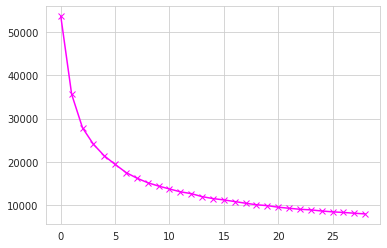

In [148]:
sns.color_palette('rocket', as_cmap=True)
plt.plot(cost, 'bx-', c='magenta')

Создадим $5$ кластеров:

In [149]:
kmean= KMeans(5)
kmean.fit(X_1)
labels = kmean.labels_

In [151]:
clusters = pd.concat([data_1, pd.DataFrame({'cluster': labels})], axis=1)
clusters.head()

balance  purchases  cash_advance  credit_limit     payments  \
0    40.900749      95.40      0.000000        1000.0   201.802084   
1  3202.467416       0.00   2784.552848        7000.0  4103.032597   
2  2495.148862     773.17      0.000000        7500.0   622.066742   
3  1666.670542    1499.00    205.788017        7500.0     0.000000   
4   817.714335      16.00      0.000000        1200.0   678.334763   

   minimum_payments  cluster  
0        139.509787        4  
1       1072.340217        3  
2        627.284787        1  
3        864.206542        1  
4        244.791237        4

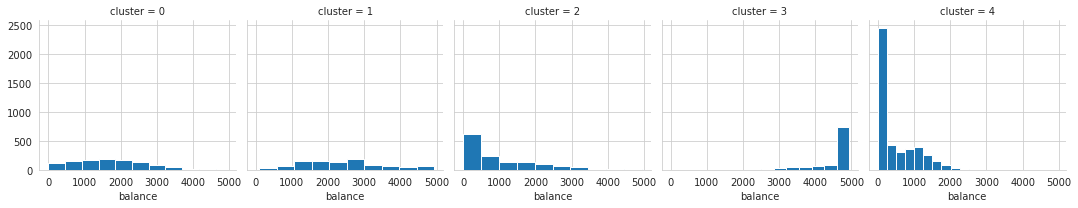

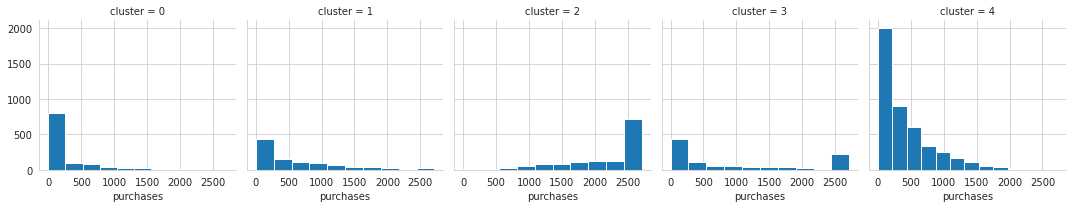

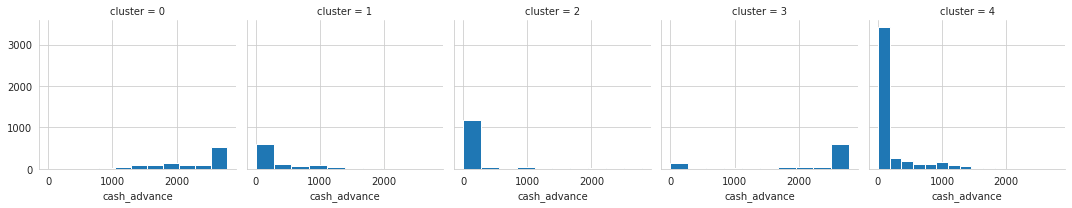

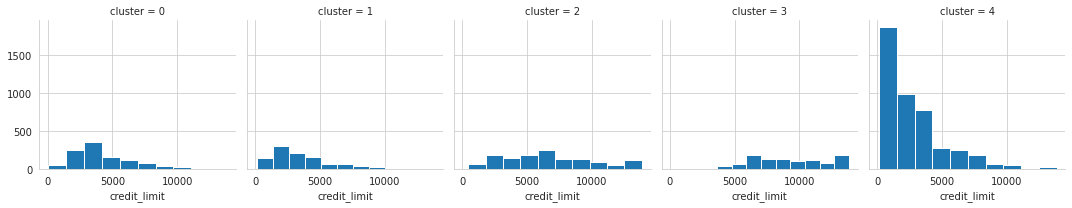

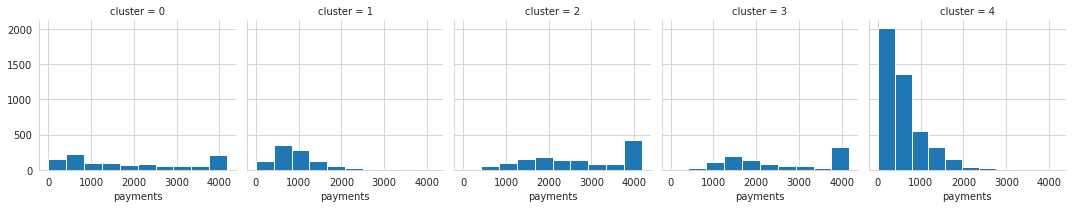

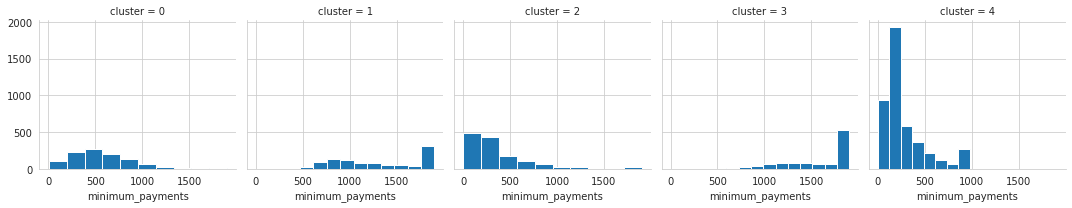

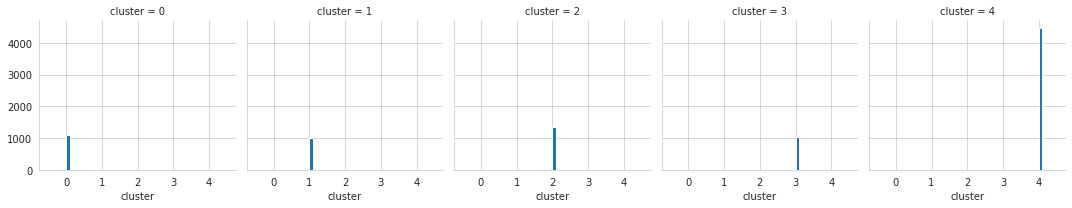

In [153]:
for c in clusters:
    grid = sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

**Описание кластеров:**

* Кластер $0$: люди почти не покупающие что-либо с кредитной картой, предоставляющие наличные деньги;
* Кластер $1$: люди со средним доходом, совершающие большинство покупок с помощью кредитной карты;
* Кластер $2$: люди с высоким уровнем дохода, тратящие почти все деньги на кредитной карте, не предоставляющие наличные деньги;
* Кластер $3$: люди с высокими тратами с высоким кредитным лимитом, совершающие дорогие покупки;
* Кластер $4$: люди, совершающие все типы покупок.

**Примечание.** Нумерация кластеров меняется при повторном запуске.

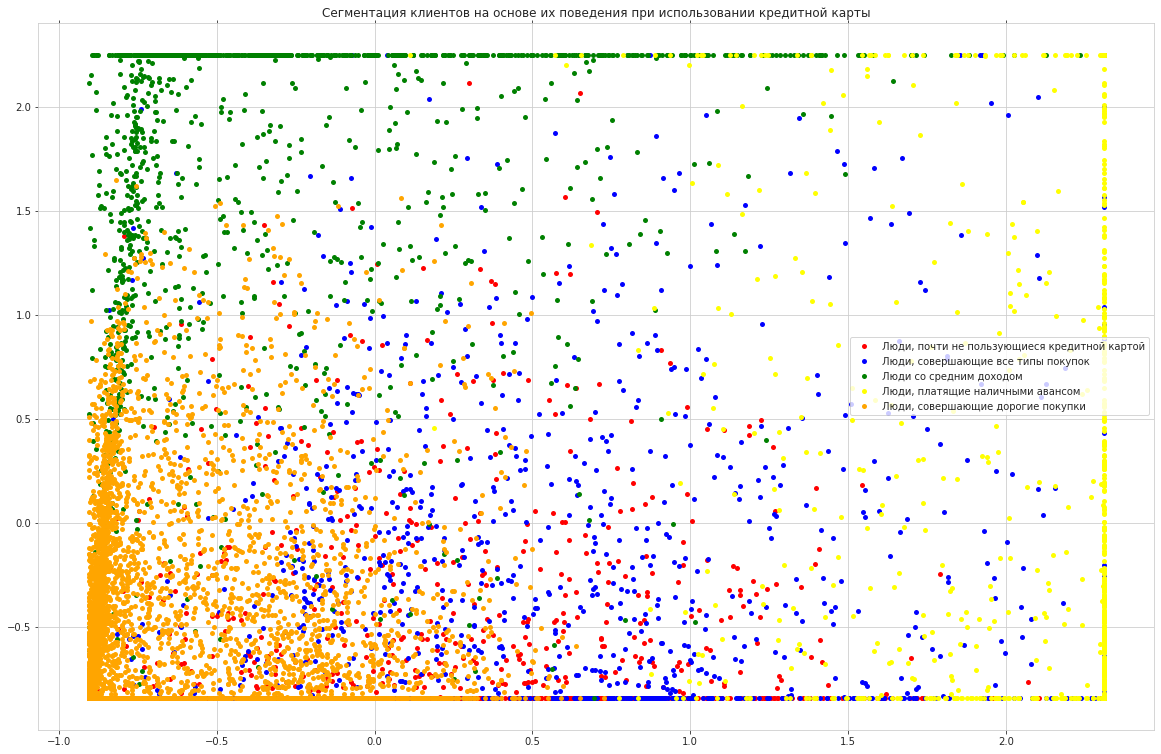

In [155]:
x, y = X_1[:, 0], X_1[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange'}

names = {0: 'Люди, почти не пользующиеся кредитной картой', 
         1: 'Люди, совершающие все типы покупок', 
         2: 'Люди со средним доходом', 
         3: 'Люди, платящие наличными авансом', 
         4: 'Люди, совершающие дорогие покупки'}

df = pd.DataFrame({'x': x, 'y': y, 'label': labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    
ax.legend()
ax.set_title("Сегментация клиентов на основе их поведения при использовании кредитной карты")
plt.show()

**Вывод по модели:**
* оптимальное число кластеров — 5;
* самый большой кластер "Люди, совершающие дорогие покупки";
* самый незначительный и при этом разреженный кластер "Люди, почти не пользующиеся кредитной картой".

## **2.2. Метод главных компонент**



**Подраздел включает в себя:**
* проверка применимости метода;
* сжатие пространственных данных;
* анализ матрицы нагрузок.

In [156]:
# подготовка данных
data_PCA = credit.drop(['cust_id'], axis=1)
data_PCA.head()

balance  balance_frequency  purchases  oneoff_purchases  \
0    40.900749           0.818182      95.40            0.0000   
1  3202.467416           0.909091       0.00            0.0000   
2  2495.148862           1.000000     773.17          773.1700   
3  1666.670542           0.722223    1499.00         1443.5125   
4   817.714335           1.000000      16.00           16.0000   

   installments_purchases  cash_advance  purchases_frequency  \
0                    95.4      0.000000             0.166667   
1                     0.0   2784.552848             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   oneoff_purchases_frequency  purchases_installments_frequency  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    0.750000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   cash_advance_frequency  cash_advance_trx  purchases_trx  credit_limit  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      payments  minimum_payments  prc_full_payment  tenure  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000        864.206542          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [157]:
X_PCA = np.asarray(data_PCA)

In [158]:
dist = 1 - cosine_similarity(X_PCA)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

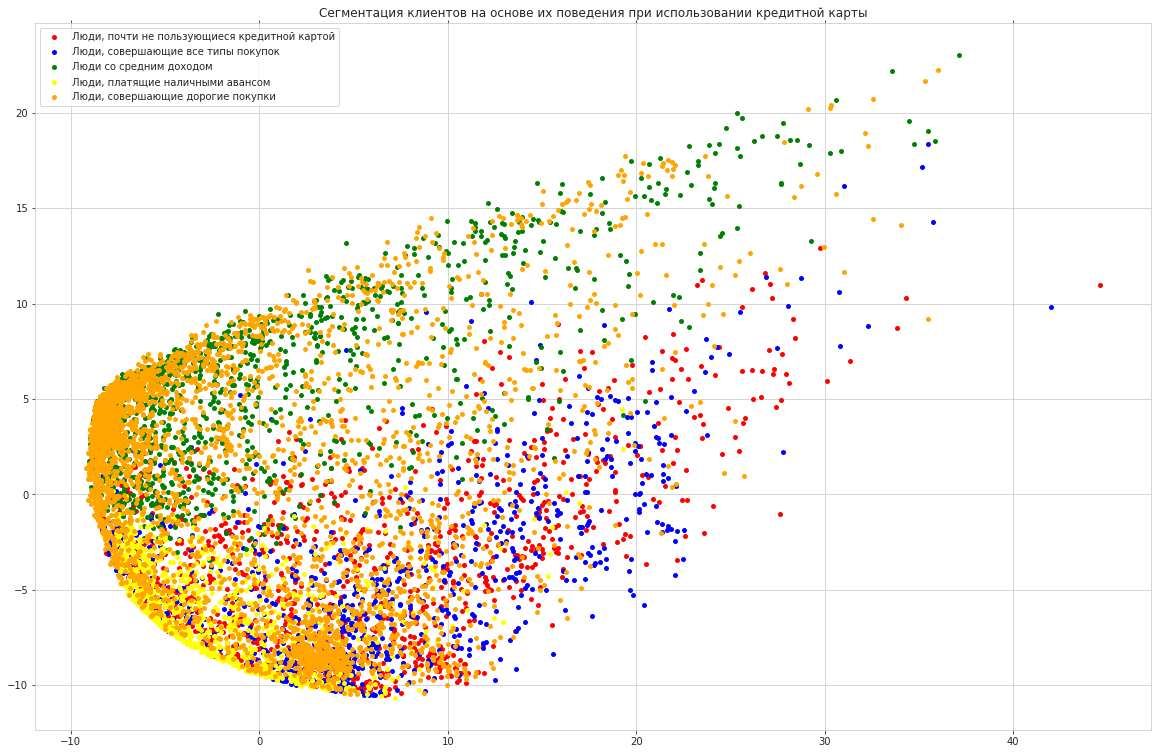

In [159]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange'}

names = {0: 'Люди, почти не пользующиеся кредитной картой', 
         1: 'Люди, совершающие все типы покупок', 
         2: 'Люди со средним доходом', 
         3: 'Люди, платящие наличными авансом', 
         4: 'Люди, совершающие дорогие покупки'}

df = pd.DataFrame({'x': x, 'y': y, 'label': labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    
ax.legend()
ax.set_title("Сегментация клиентов на основе их поведения при использовании кредитной карты")
plt.show()

### 2.2.1. Проверка применимости метода

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bec543460>,
      dtype=object)

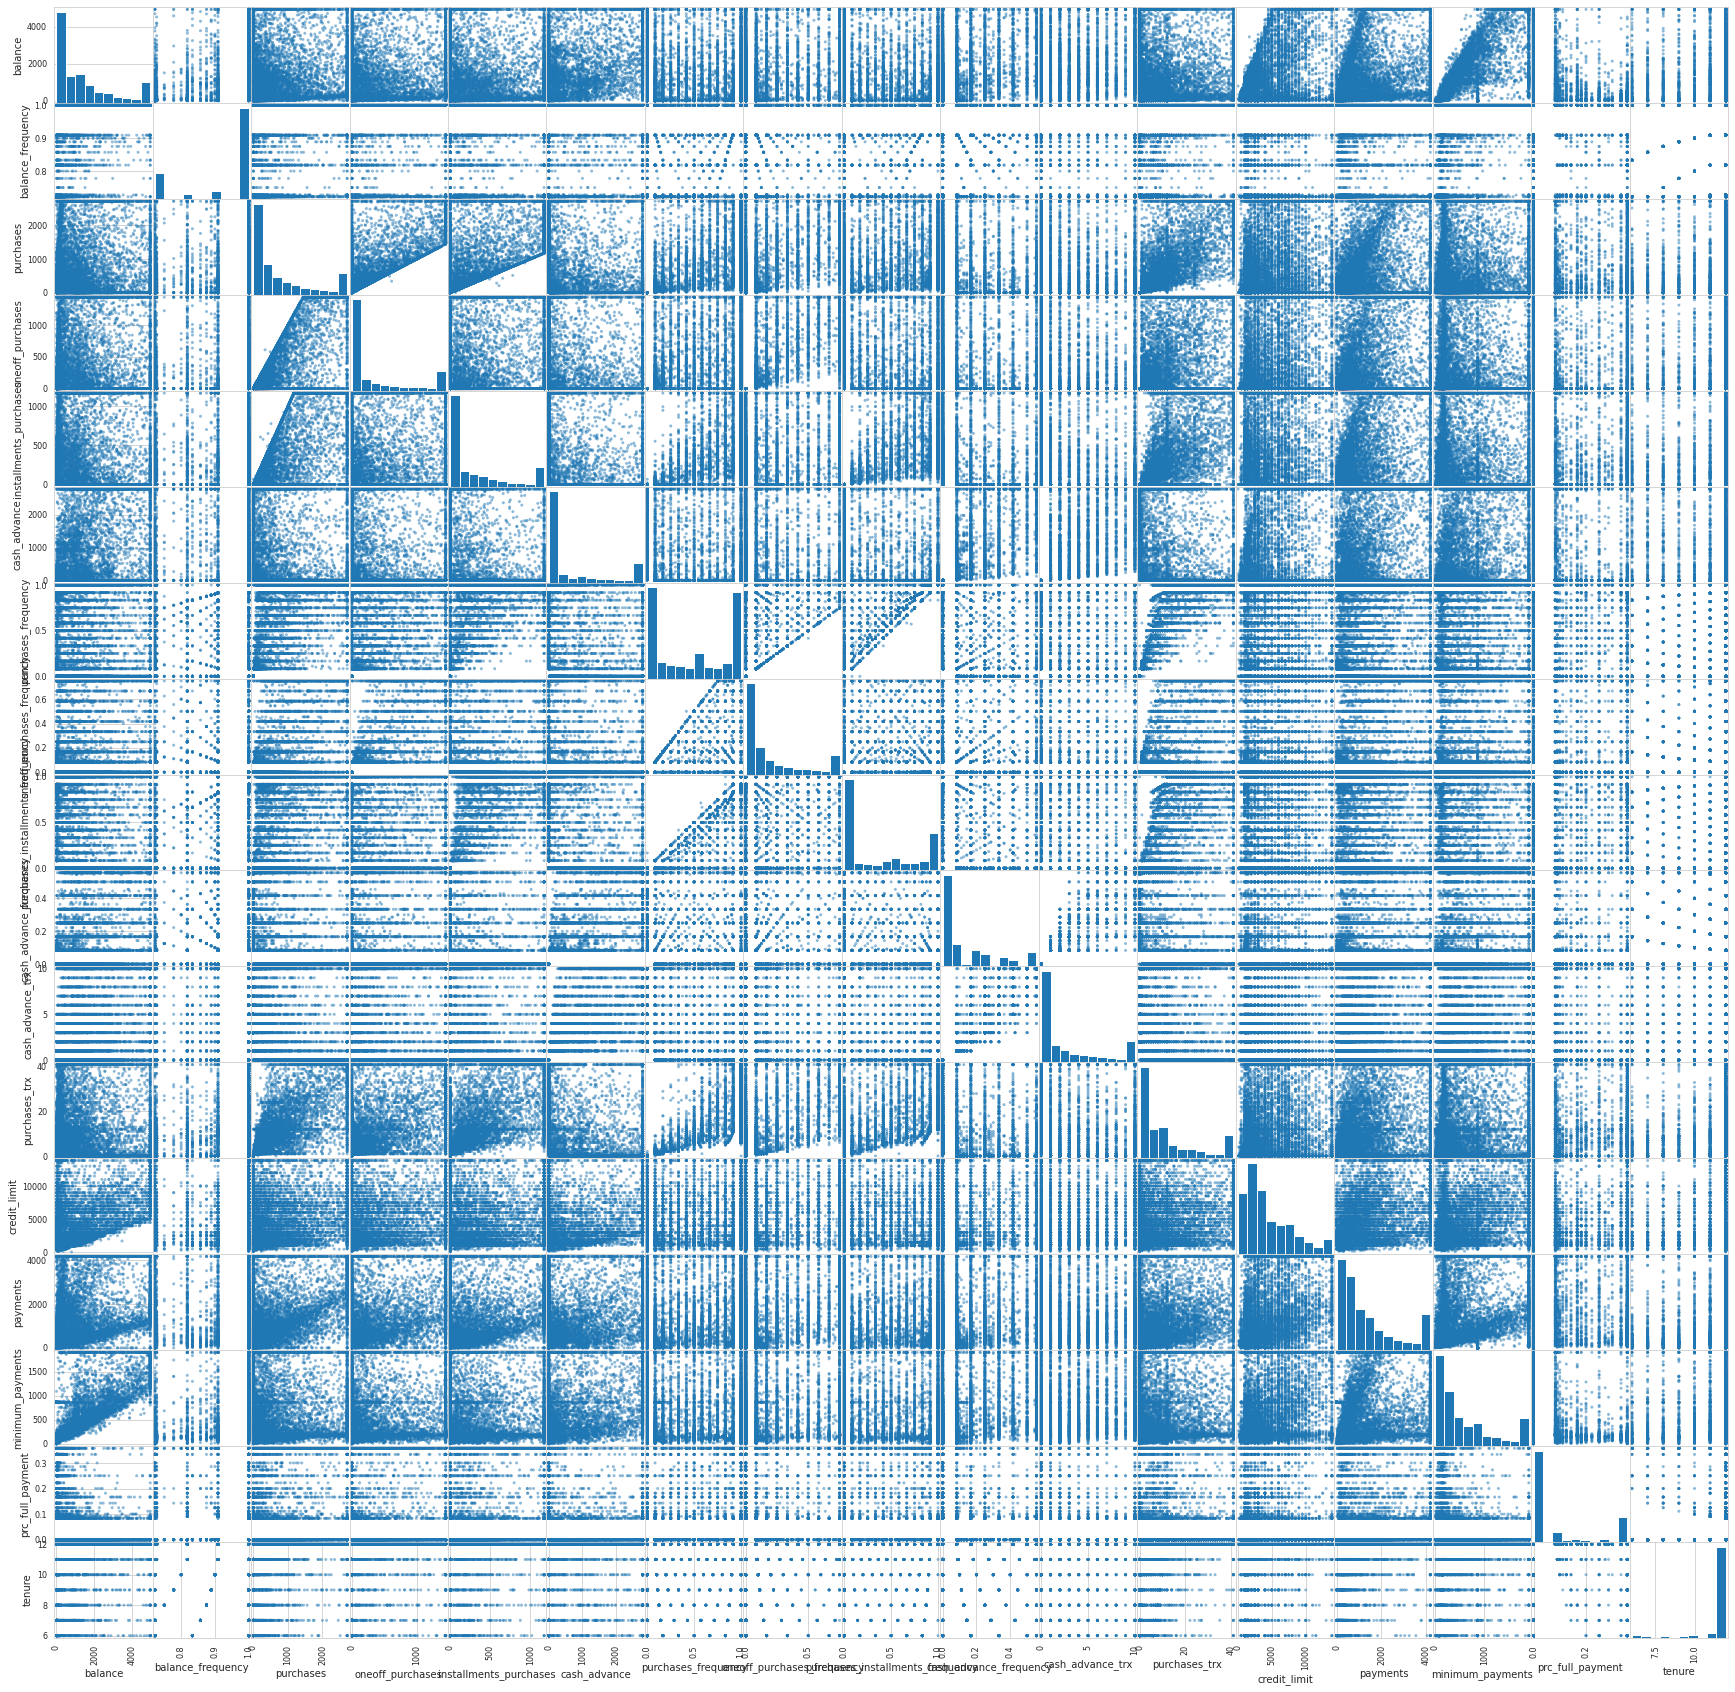

In [162]:
# (1) графически, диаграммы рассеяния

scatter_matrix(data_PCA, figsize=(30, 30))

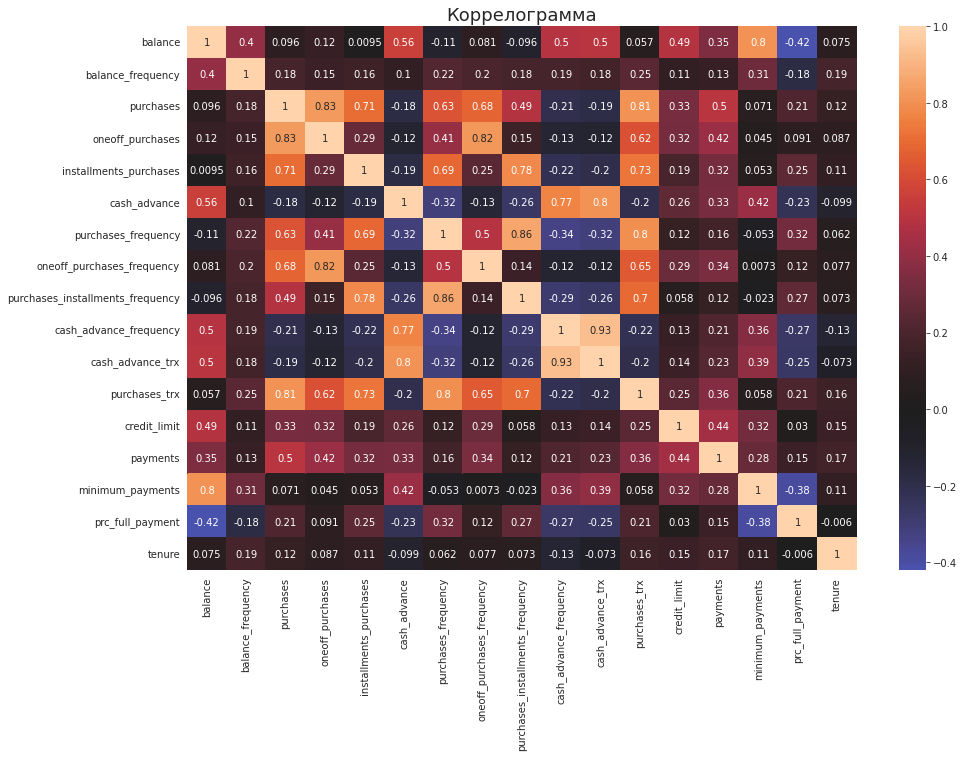

In [165]:
# (2) наличие корреляции
# коррелограмма

dataCor = data_PCA.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(dataCor, xticklabels=dataCor.columns, \
            yticklabels=dataCor.columns, \
            center=0, annot=True)
plt.title('Коррелограмма', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [166]:
# (3) проверка применимости МГК (КМО)

kmo_all, kmo_model = calculate_kmo(data_PCA)

print(kmo_all)
print(kmo_model)
data_PCA.columns

[0.72189771 0.76420209 0.71057811 0.64155897 0.69824647 0.89131683
 0.72534727 0.64132998 0.6285803  0.76308806 0.74502178 0.9017192
 0.78410016 0.86190167 0.73497946 0.83706249 0.54395575]
0.7370697501922849


Index(['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure'],
      dtype='object')

**Вывод:** значение получилось равным $0.7$, что указывает на относительно высокую корреляцию между переменными - исходные переменные подходят для факторного анализа.

In [167]:
# (4) проверка применимости МГК (Тест сферичности Бартлетта)
chi_square_value, p_value = calculate_bartlett_sphericity(data)
chi_square_value, p_value

(137594.66612054643, 0.0)

**Вывод:** тест Бартлетта сравнивает наблюдаемую корреляционную матрицу с единичной матрицей, и, как видно из результата выше, разница между ними велика.

**Таким образом, метод МГК может быть применен в нашем случае.**

### 2.2.2. Выполнение сжатия пространства переменных

In [168]:
sc = StandardScaler() 
data_sc = sc.fit_transform(data_PCA) 

In [169]:
type(data_sc)

numpy.ndarray

In [170]:
data_2 = pd.DataFrame(data_sc)
data_2.columns = data_2.columns + 1
data_2.index = data_2.index + 1
data_2.head()

1         2         3         4         5         6         7   \
1 -0.877821 -1.021875 -0.729687 -0.692383 -0.505216 -0.673507 -0.806490   
2  1.178546 -0.202708 -0.838160 -0.692383 -0.746029  2.115343 -1.221758   
3  0.718487  0.616459  0.040957  0.818320 -0.746029 -0.673507  1.269843   
4  0.179623 -1.886552  0.866246  2.128108 -0.746029 -0.467401 -1.014125   
5 -0.372561  0.616459 -0.819967 -0.661121 -0.746029 -0.673507 -1.014125   

         8         9         10        11        12        13        14  \
1 -0.722749 -0.707313 -0.730084 -0.697293 -0.737970 -1.010562 -0.899859   
2 -0.722749 -0.916995  0.717792  0.473089 -0.891333  0.762715  2.165375   
3  2.210909 -0.916995 -0.730084 -0.697293  0.028848  0.910488 -0.569653   
4 -0.396788 -0.916995 -0.247460 -0.404697 -0.814651  0.910488 -1.058417   
5 -0.396788 -0.916995 -0.730084 -0.697293 -0.814651 -0.951453 -0.525443   

         15        16       17  
1 -0.794047 -0.629277  0.36068  
2  0.836751  0.973961  0.36068  
3  0.058694 -0.629277  0.36068  
4  0.472886 -0.629277  0.36068  
5 -0.609992 -0.629277  0.36068

Найдем корреляционную матрицу:

In [171]:
dcorr = data_2.corr()
dcorr

1         2         3         4         5         6         7   \
1   1.000000  0.403457  0.095805  0.124043  0.009457  0.557393 -0.108922   
2   0.403457  1.000000  0.184972  0.149539  0.161057  0.102849  0.222217   
3   0.095805  0.184972  1.000000  0.830603  0.706135 -0.177093  0.631891   
4   0.124043  0.149539  0.830603  1.000000  0.286764 -0.116870  0.408137   
5   0.009457  0.161057  0.706135  0.286764  1.000000 -0.185467  0.688315   
6   0.557393  0.102849 -0.177093 -0.116870 -0.185467  1.000000 -0.319499   
7  -0.108922  0.222217  0.631891  0.408137  0.688315 -0.319499  1.000000   
8   0.081477  0.199187  0.683525  0.821933  0.249382 -0.134830  0.499498   
9  -0.096473  0.180675  0.488919  0.152872  0.780193 -0.264589  0.862934   
10  0.497089  0.186646 -0.207612 -0.127137 -0.220042  0.769767 -0.336823   
11  0.500925  0.175467 -0.190023 -0.117956 -0.200208  0.801425 -0.315382   
12  0.057123  0.248062  0.808546  0.622341  0.725475 -0.203801  0.795194   
13  0.488516  0.107968  0.330410  0.321476  0.191926  0.258418  0.118192   
14  0.350558  0.133318  0.501153  0.422124  0.324137  0.331303  0.163930   
15  0.802934  0.306531  0.071449  0.045047  0.052574  0.420883 -0.052645   
16 -0.419972 -0.183459  0.212936  0.091038  0.254259 -0.227197  0.316356   
17  0.075417  0.186697  0.120207  0.087002  0.111298 -0.099027  0.061506   

          8         9         10        11        12        13        14  \
1   0.081477 -0.096473  0.497089  0.500925  0.057123  0.488516  0.350558   
2   0.199187  0.180675  0.186646  0.175467  0.248062  0.107968  0.133318   
3   0.683525  0.488919 -0.207612 -0.190023  0.808546  0.330410  0.501153   
4   0.821933  0.152872 -0.127137 -0.117956  0.622341  0.321476  0.422124   
5   0.249382  0.780193 -0.220042 -0.200208  0.725475  0.191926  0.324137   
6  -0.134830 -0.264589  0.769767  0.801425 -0.203801  0.258418  0.331303   
7   0.499498  0.862934 -0.336823 -0.315382  0.795194  0.118192  0.163930   
8   1.000000  0.143475 -0.121845 -0.118664  0.650300  0.293008  0.336919   
9   0.143475  1.000000 -0.285161 -0.264110  0.700146  0.057750  0.120975   
10 -0.121845 -0.285161  1.000000  0.930204 -0.217631  0.128309  0.213939   
11 -0.118664 -0.264110  0.930204  1.000000 -0.197190  0.142802  0.234369   
12  0.650300  0.700146 -0.217631 -0.197190  1.000000  0.251113  0.363262   
13  0.293008  0.057750  0.128309  0.142802  0.251113  1.000000  0.438942   
14  0.336919  0.120975  0.213939  0.234369  0.363262  0.438942  1.000000   
15  0.007255 -0.023301  0.360433  0.392387  0.057724  0.315850  0.284977   
16  0.123273  0.266671 -0.268737 -0.254650  0.211653  0.030297  0.146739   
17  0.077257  0.073275 -0.127145 -0.072771  0.156168  0.145629  0.169454   

          15        16        17  
1   0.802934 -0.419972  0.075417  
2   0.306531 -0.183459  0.186697  
3   0.071449  0.212936  0.120207  
4   0.045047  0.091038  0.087002  
5   0.052574  0.254259  0.111298  
6   0.420883 -0.227197 -0.099027  
7  -0.052645  0.316356  0.061506  
8   0.007255  0.123273  0.077257  
9  -0.023301  0.266671  0.073275  
10  0.360433 -0.268737 -0.127145  
11  0.392387 -0.254650 -0.072771  
12  0.057724  0.211653  0.156168  
13  0.315850  0.030297  0.145629  
14  0.284977  0.146739  0.169454  
15  1.000000 -0.384348  0.106581  
16 -0.384348  1.000000 -0.005955  
17  0.106581 -0.005955  1.000000

Найдем собственные числа и собственые векторы:

In [172]:
eigenvalues, eigenvectors = np.linalg.eig(dcorr)

In [173]:
eigenvalues

array([5.36540979, 4.02314388, 1.54270446, 1.35780212, 1.07825053,
       0.8870764 , 0.63985836, 0.52864198, 0.43908958, 0.32293619,
       0.02838477, 0.05365757, 0.06336063, 0.12564063, 0.14017922,
       0.2188077 , 0.1850562 ])

In [175]:
pd.DataFrame(eigenvectors, columns=dcorr.columns, index=data_PCA.columns)

1         2         3         4   \
balance                           0.041841  0.428534 -0.093333 -0.231396   
balance_frequency                -0.083745  0.214238 -0.252633 -0.331002   
purchases                        -0.380075  0.128094  0.152787  0.034004   
oneoff_purchases                 -0.295435  0.143937  0.449224 -0.071454   
installments_purchases           -0.333524  0.045864 -0.333006  0.150098   
cash_advance                      0.177994  0.365172 -0.029829  0.302200   
purchases_frequency              -0.370648 -0.019923 -0.251479  0.079793   
oneoff_purchases_frequency       -0.289762  0.122132  0.413597 -0.073118   
purchases_installments_frequency -0.314325 -0.035226 -0.489049  0.132751   
cash_advance_frequency            0.196599  0.351326 -0.056682  0.302858   
cash_advance_trx                  0.188462  0.360974 -0.066542  0.303175   
purchases_trx                    -0.389644  0.094923 -0.072979  0.032044   
credit_limit                     -0.113397  0.271026  0.173112 -0.020672   
payments                         -0.157986  0.288887  0.175784  0.210732   
minimum_payments                  0.032928  0.362352 -0.190081 -0.281599   
prc_full_payment                 -0.159017 -0.167390  0.079401  0.471896   
tenure                           -0.079081  0.048537 -0.028185 -0.394914   

                                        5         6         7         8   \
balance                          -0.034353  0.247008  0.123596  0.060368   
balance_frequency                 0.245893 -0.450615  0.559744  0.279348   
purchases                         0.060603  0.037165 -0.184583  0.130485   
oneoff_purchases                  0.204397 -0.035284 -0.102704  0.018813   
installments_purchases           -0.102017  0.102692 -0.207895  0.080848   
cash_advance                     -0.025578 -0.043661 -0.049676 -0.087123   
purchases_frequency               0.140653 -0.010627  0.095778 -0.203337   
oneoff_purchases_frequency        0.275369 -0.124611  0.081858 -0.164920   
purchases_installments_frequency  0.003624  0.053634 -0.038705 -0.146172   
cash_advance_frequency            0.168284 -0.236651 -0.065604 -0.162572   
cash_advance_trx                  0.121051 -0.252383 -0.107089 -0.185351   
purchases_trx                     0.111272 -0.042714 -0.114229 -0.135795   
credit_limit                     -0.405716  0.345996  0.438248 -0.493697   
payments                         -0.342270 -0.044392 -0.149872  0.550476   
minimum_payments                 -0.066187  0.315385 -0.066103  0.256339   
prc_full_payment                 -0.332581 -0.179136  0.487795  0.211053   
tenure                           -0.578032 -0.572338 -0.279420 -0.246299   

                                        9         10        11        12  \
balance                           0.143941 -0.075667  0.003141 -0.037970   
balance_frequency                -0.297003 -0.037595  0.002444  0.018906   
purchases                        -0.132198 -0.376029 -0.562137 -0.472664   
oneoff_purchases                  0.031116 -0.177152  0.438496  0.332740   
installments_purchases           -0.268081 -0.425566  0.333838  0.198976   
cash_advance                     -0.000655  0.212993 -0.016898 -0.003183   
purchases_frequency               0.219676  0.372071  0.344574 -0.503045   
oneoff_purchases_frequency        0.234178  0.205546 -0.272396  0.267774   
purchases_installments_frequency  0.014492  0.202616 -0.413346  0.518081   
cash_advance_frequency           -0.003644 -0.162011  0.014671 -0.080102   
cash_advance_trx                  0.066304 -0.139882 -0.007450  0.054603   
purchases_trx                     0.072109  0.058376  0.121188 -0.134298   
credit_limit                     -0.311452 -0.025622  0.001353 -0.004245   
payments                         -0.247762  0.493388  0.034670  0.013026   
minimum_payments                  0.549422 -0.085413 -0.003129  0.048026   
prc_full_payment                  0.455533 -0.264578 -0.002399  0.033734   
tenure    

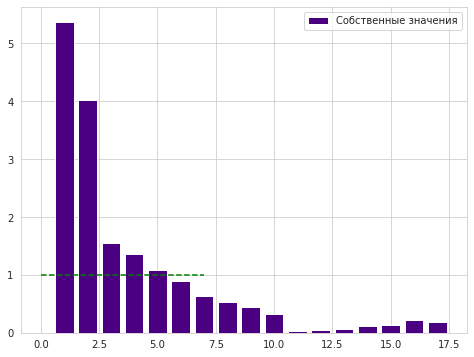

In [176]:
# Критерий Кайзера

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.bar(range(1, len(eigenvalues) + 1), eigenvalues, label='Собственные значения', color='indigo')
ax.plot(np.full(8, 1), '--', color='green')
ax.legend()
plt.show()

При первом приближении стоит отобрать $5$ факторов.

Найдем Главные компоненты, признаки в новой системе координат Матрица счетов (матрица компонентов), обозначается Т (scores):

In [179]:
score = data_sc@(eigenvectors)    # data_sc.dot(eigenvectors)

In [180]:
score.shape

(8950, 17)

In [186]:
pd.DataFrame(score).head()

0         1         2         3         4         5         6   \
0  1.624789 -2.381615  0.255016 -0.659427 -0.171144  0.005619 -0.901622   
1  2.158390  2.289497  0.557901  1.030608 -2.194329  0.060201  0.500140   
2 -1.198983  0.280708  1.535004 -1.951334  0.792513  0.099595  1.060954   
3  0.495849 -0.185931  2.271893 -1.004749 -0.368661  1.419361 -1.056770   
4  1.632622 -1.597279  0.210639 -1.404927  0.126787 -0.621528  0.122685   

         7         8         9         10        11        12        13  \
0 -0.115766 -0.199634 -0.042360  0.030636 -0.077022 -0.043520  0.030087   
1  1.212492  0.211724  0.807729  0.009792  0.088456  0.272555 -0.004628   
2 -0.979777  0.536998  0.739019  0.295807 -0.449604 -0.134565  0.901489   
3 -0.883699  0.327436 -1.455257  0.202691  0.123402  0.214993 -0.063738   
4  0.595371 -0.523931  0.098988 -0.050180  0.046790 -0.095680  0.034283   

         14        15        16  
0 -0.083088  0.087917 -0.162744  
1 -0.267064  0.627490 -0.157175  
2  0.200675 -0.110590 -0.459347  
3  0.158221  0.236042  1.532319  
4 -0.148259  0.091617 -0.301764

In [182]:
# Главные Факторы - нормированные главные компоненты
factors1 = np.array([np.array(a / np.sqrt(b)) for a, b in zip(score.T, eigenvalues)]).T
factors1.shape

(8950, 17)

In [187]:
pd.DataFrame(factors1).head()

0         1         2         3         4         5         6   \
0  0.701448 -1.187377  0.205317 -0.565912 -0.164817  0.005965 -1.127152   
1  0.931812  1.141451  0.449175  0.884454 -2.113206  0.063917  0.625244   
2 -0.517620  0.139949  1.235857 -1.674609  0.763214  0.105745  1.326339   
3  0.214066 -0.092698  1.829138 -0.862262 -0.355032  1.506997 -1.321109   
4  0.704830 -0.796339  0.169589 -1.205690  0.122100 -0.659903  0.153373   

         7         8         9         10        11        12        13  \
0 -0.159221 -0.301272 -0.074542  0.181837 -0.332508 -0.172894  0.084880   
1  1.667624  0.319517  1.421371  0.058118  0.381867  1.082790 -0.013057   
2 -1.347554  0.810393  1.300461  1.755761 -1.940952 -0.534592  2.543286   
3 -1.215412  0.494141 -2.560833  1.203073  0.532728  0.854113 -0.179818   
4  0.818855 -0.790674  0.174190 -0.297845  0.201996 -0.380111  0.096719   

         14        15        16  
0 -0.221921  0.187949 -0.378315  
1 -0.713302  1.341454 -0.365369  
2  0.535983 -0.236420 -1.067797  
3  0.422593  0.504613  3.562028  
4 -0.395985  0.195859 -0.701481

**Выводы по сжатию пространства данных:**
* критерий Кайзера показал для первичного отбора $5$ факторов;
* были получены нормированные главные компоненты.

### 2.2.3. Анализ матрицы нагрузок

In [189]:
from scipy.stats.stats import pearsonr

matrix_p = np.array([[pearsonr(data_sc[:,i],factors1[:,j])[0] for j in range(0, factors1.shape[1])] for i in range(0,factors1.shape[1])])
pd.DataFrame(matrix_p)

0         1         2         3         4         5         6   \
0   0.096917  0.859543 -0.115925 -0.269634 -0.035672  0.232644  0.098866   
1  -0.193981  0.429713 -0.313785 -0.385699  0.255333 -0.424410  0.447745   
2  -0.880382  0.256929  0.189770  0.039623  0.062930  0.035004 -0.147650   
3  -0.684327  0.288706  0.557961 -0.083262  0.212243 -0.033233 -0.082154   
4  -0.772554  0.091994 -0.413612  0.174902 -0.105933  0.096721 -0.166298   
5   0.412294  0.732454 -0.037049  0.352137 -0.026559 -0.041122 -0.039736   
6  -0.858545 -0.039961 -0.312351  0.092978  0.146052 -0.010009  0.076614   
7  -0.671187  0.244970  0.513711 -0.085200  0.285940 -0.117365  0.065479   
8  -0.728082 -0.070656 -0.607427  0.154688  0.003763  0.050515 -0.030961   
9   0.455390  0.704681 -0.070403  0.352904  0.174744 -0.222889 -0.052478   
10  0.436542  0.724034 -0.082649  0.353274  0.125698 -0.237706 -0.085662   
11 -0.902546  0.190395 -0.090644  0.037339  0.115543 -0.040230 -0.091373   
12 -0.262665  0.543618  0.215015 -0.024089 -0.421290  0.325875  0.350560   
13 -0.365948  0.579442  0.218334  0.245555 -0.355409 -0.041811 -0.119884   
14  0.076272  0.726797 -0.236091 -0.328133 -0.068728  0.297045 -0.052877   
15 -0.368336 -0.335746  0.098620  0.549876 -0.345349 -0.168719  0.390192   
16 -0.183179  0.097354 -0.035008 -0.460173 -0.600221 -0.539055 -0.223511   

          7         8         9         10        11        12        13  \
0   0.043892  0.095381 -0.043000  0.000529 -0.008795 -0.028450  0.144711   
1   0.203108 -0.196805 -0.021364  0.000412  0.004379 -0.001120 -0.036459   
2   0.094872 -0.087600 -0.213688 -0.094708 -0.109488 -0.005226  0.012802   
3   0.013678  0.020619 -0.100671  0.073877  0.077076  0.011728 -0.016121   
4   0.058783 -0.177641 -0.241838  0.056244  0.046091  0.001625  0.097091   
5  -0.063345 -0.000434  0.121039 -0.002847 -0.000737  0.028679 -0.019914   
6  -0.147842  0.145566  0.211438  0.058053 -0.116526 -0.008888  0.108795   
7  -0.119910  0.155175  0.116807 -0.045893  0.062028  0.004792  0.101760   
8  -0.106279  0.009603  0.115142 -0.069640  0.120009  0.015775 -0.000535   
9  -0.118202 -0.002415 -0.092067  0.002472 -0.018555  0.166960  0.021489   
10 -0.134764  0.043936 -0.079491 -0.001255  0.012648 -0.180423 -0.013029   
11 -0.098734  0.047782  0.033173  0.020417 -0.031109 -0.005061 -0.244368   
12 -0.358956 -0.206380 -0.014560  0.000228 -0.000983  0.002249 -0.046495   
13  0.400239 -0.164177  0.280380  0.005841  0.003017 -0.006390  0.006855   
14  0.186378  0.364068 -0.048538 -0.000527  0.011125  0.023932 -0.087508   
15  0.153452  0.301854 -0.150353 -0.000404  0.007814  0.002284 -0.002398   
16 -0.179079  0.093896 -0.020192 -0.000575 -0.003601  0.011477  0.026686   

          14        15        16  
0  -0.252344  0.045530  0.005500  
1   0.043988  0.031164  0.001292  
2   0.036422  0.055016  0.080673  
3  -0.000005  0.066838  0.224011  
4   0.059947  0.023817 -0.180068  
5   0.055773  0.374225 -0.033631  
6   0.068908 -0.020544  0.077508  
7   0.048345 -0.034586 -0.215755  
8  -0.029395 -0.008376  0.152985  
9  -0.033063 -0.175793  0.020962  
10  0.038734 -0.110280  0.031214  
11 -0.158170 -0.000956 -0.130211  
12  0.063096 -0.064076  0.013914  
13 -0.010852 -0.117931  0.003422  
14  0.159440 -0.057572 -0.007448  
15 -0.038088  0.027101  0.002250  
16 -0.002072  0.029009  0.013537

**Выводы по анализу матрицы нагрузок:**
* первые факторы имеет более сильную корреляцию с переменными, чем остальные.

## **2.3. Кластерный анализ на новых переменных**



* построение модели кластеризации: метод `k-means`;
* описание полученных кластеров;
* выбор наилучшей модели.

### 2.3.1. Метод $k$-средних

In [190]:
pca = PCA(n_components=2)
score_new = pca.fit_transform(data_sc)  # Главные компоненты
type(score_new)

numpy.ndarray

In [191]:
pca.components_

array([[-0.04184057,  0.08374457,  0.38007536,  0.29543519,  0.33352425,
        -0.177994  ,  0.37064803,  0.28976243,  0.31432481, -0.19659925,
        -0.18846232,  0.38964398,  0.11339669,  0.15798559, -0.03292805,
         0.15901653,  0.0790814 ],
       [ 0.42853362,  0.21423758,  0.12809426,  0.14393704,  0.04586446,
         0.36517195, -0.01992292,  0.12213201, -0.0352264 ,  0.35132581,
         0.36097411,  0.09492346,  0.27102619,  0.28888667,  0.36235155,
        -0.16738954,  0.04853688]])

In [192]:
pca.explained_variance_

array([5.36600935, 4.02359344])

In [193]:
pca.explained_variance_ratio_

array([0.31561234, 0.23665552])

In [194]:
pd.DataFrame(score_new)

0         1
0    -1.624789 -2.381614
1    -2.158390  2.289497
2     1.198983  0.280708
3    -0.495848 -0.185934
4    -1.632623 -1.597278
...        ...       ...
8945  0.320141 -2.739867
8946 -0.131127 -1.803645
8947 -0.463207 -2.990445
8948 -2.418519 -2.466632
8949  0.180086 -0.908286

[8950 rows x 2 columns]

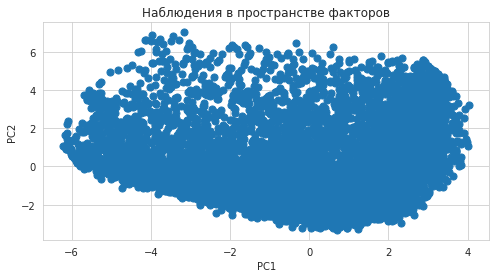

In [195]:
fig, ax = plt.subplots(1,1, figsize = (8, 4))
ax.scatter(-score_new[:, 0], score_new[:, 1],s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.set_title('Наблюдения в пространстве факторов')
plt.show()

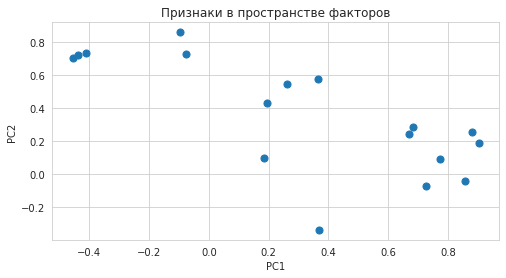

In [196]:
fig, ax = plt.subplots(1,1, figsize = (8, 4))
ax.scatter(-matrix_p[:, 0], matrix_p[:, 1],s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.set_title('Признаки в пространстве факторов')
plt.show()

In [197]:
X_3 = np.asarray(score_new)

Сделаем кластеризацию с использованием $k$-средних:

In [198]:
n_clusters = 30
cost = []

for i in range(1, n_clusters):
    kmean = KMeans(i)
    kmean.fit(X_3)
    cost.append(kmean.inertia_)  

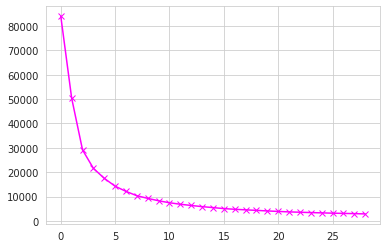

In [199]:
sns.color_palette('rocket', as_cmap=True)
plt.plot(cost, 'bx-', c='magenta')

Создадим $3$ кластера:

In [200]:
kmean= KMeans(3)
kmean.fit(X_3)
labels = kmean.labels_

In [202]:
clusters = pd.concat([pd.DataFrame(score_new), pd.DataFrame({'cluster': labels})], axis=1)
clusters.head()

0         1  cluster
0 -1.624789 -2.381614        2
1 -2.158390  2.289497        0
2  1.198983  0.280708        1
3 -0.495848 -0.185934        2
4 -1.632623 -1.597278        2

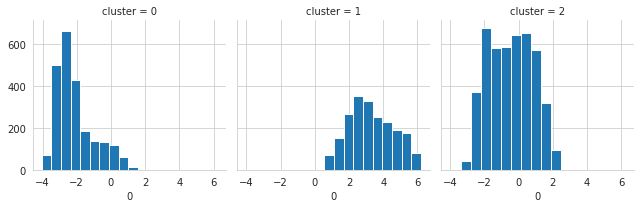

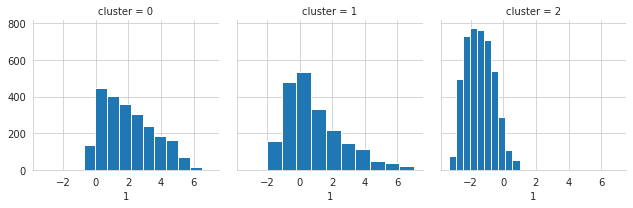

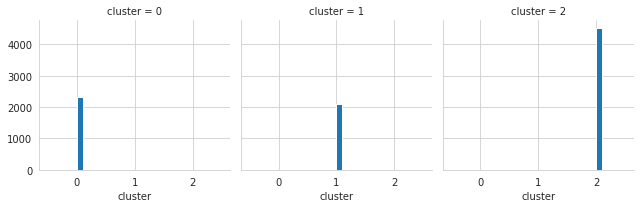

In [203]:
for c in clusters:
    grid = sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

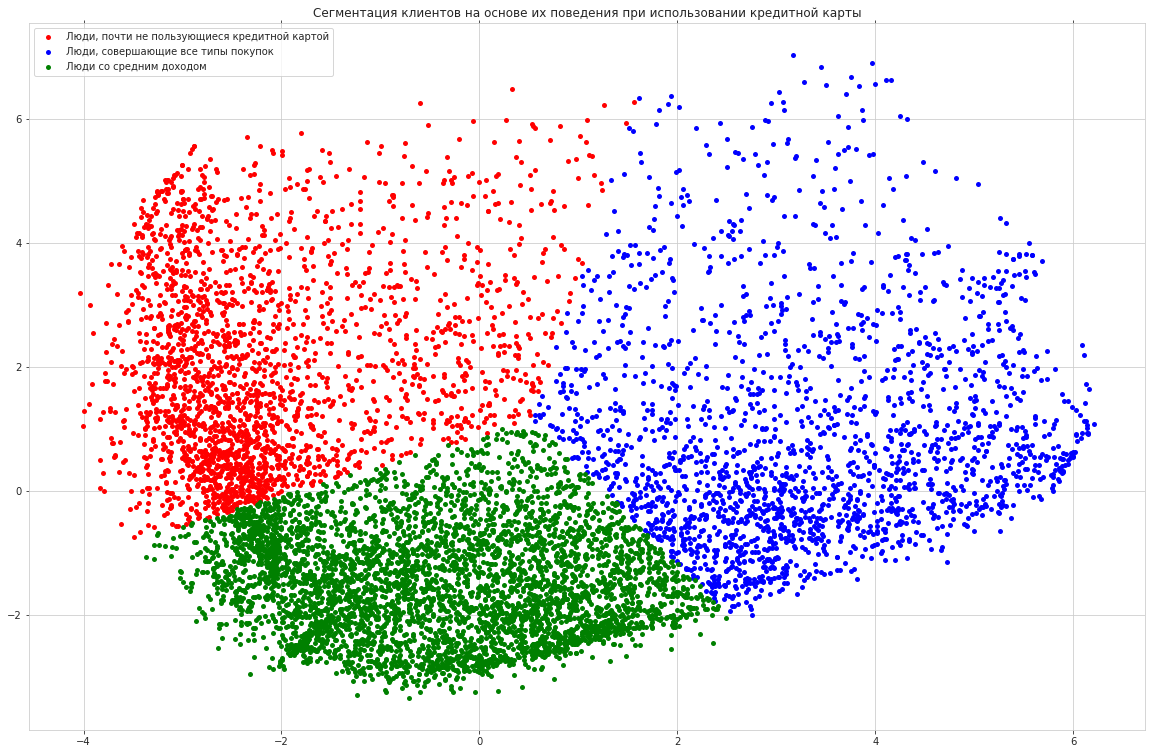

In [204]:
x, y = X_3[:, 0], X_3[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green'}

names = {0: 'Люди, почти не пользующиеся кредитной картой', 
         1: 'Люди, совершающие все типы покупок', 
         2: 'Люди со средним доходом'}

df = pd.DataFrame({'x': x, 'y': y, 'label': labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    
ax.legend()
ax.set_title("Сегментация клиентов на основе их поведения при использовании кредитной карты")
plt.show()

**Вывод по модели:**
* Кластеры были разделены по значениям компонент и на рисунке мы наблюдаем четкое разделение групп людей относительно веса компоненты во всех исходных переменных;
* оптимальное число кластеров — 3.

# **3. Итоги**


---

Таким образом, в данной работе были предварительно обработаны данные в наборе данных `CC General.csv`, после чего был выполнен кластерный анализ, в результате чего было получено $5$ кластеров - групп людей согласно их поведению при покупке товаров.

  **Далее был применен Метод Главных Компонент:** 
* Была проведена проверка на применимость метода, в результате чего былf выявлена возможная применимость метода;
* Было выполнено сжатие пространства переменных и проанализирована матрица нагрузок, из чего было выяснено, что первые компоненты объясняют переменные глубже, чем последние.

**После был выполнен кластерный анализ на новых переменных:**
* Выполнив кластерный анализ на отобранных Главных компонентах, мы выяснили, что оптимальным числом кластеров является $3$ кластера;
* Модель на новых переменных оказалась более адекватной, так как все наблюдения разделы на кластеры с четкими (без смешивания) границами. 